# VRS file

In [1]:
import os

ego_exo_root = os.path.join('/data2', 'EgoExo4D') # Replace with your cli's download directory for Ego-Exo4D
take_name = 'cmu_bike01_5'

ego_exo_project_path = os.path.join(ego_exo_root, 'takes', take_name)
print(f'EgoExo Sequence: {ego_exo_project_path}')

if not os.path.exists(ego_exo_project_path):
    print("Please do update your path to a valid EgoExo sequence folder.")

EgoExo Sequence: /data2/EgoExo4D/takes/cmu_bike01_5


In [6]:
from projectaria_tools.core import data_provider

vrs_file_path = os.path.join(ego_exo_project_path, 'aria01_noimagestreams.vrs')
print(vrs_file_path)
assert os.path.exists(vrs_file_path), "We are not finding the required vrs file"

vrs_data_provider = data_provider.create_vrs_data_provider(vrs_file_path)
if not vrs_data_provider:
    print("Couldn't create data vrs_data_provider from vrs file")
    exit(1)

/data2/EgoExo4D/takes/cmu_bike01_5/aria01_noimagestreams.vrs


[MultiRecordFileReader][DEBUG]: Opened file '/data2/EgoExo4D/takes/cmu_bike01_5/aria01_noimagestreams.vrs' and assigned to reader #0
[VrsDataProvider][INFO]: streamId 231-1/mic activated
[VrsDataProvider][INFO]: streamId 247-1/baro0 activated
[VrsDataProvider][WARNING]: Unsupported TimeSync mode: APP, ignoring.
[VrsDataProvider][INFO]: Fail to activate streamId 286-1
[VrsDataProvider][INFO]: streamId 1202-1/imu-right activated
[VrsDataProvider][INFO]: streamId 1202-2/imu-left activated
[VrsDataProvider][INFO]: streamId 1203-1/mag0 activated


In [22]:
device_calib = vrs_data_provider.get_device_calibration()
for stream in vrs_data_provider.get_all_streams():
    label = vrs_data_provider.get_label_from_stream_id(stream)
    imu_calib = device_calib.get_imu_calib(label)
    print(imu_calib)

None
None
ImuCalibration(label: imu-right, T_Device_Imu: (translation:[0.00464047, -0.104926, -0.0900838], quaternion(x,y,z,w):[-0.779245, -0.084267, 0.0518807, 0.618858]))
ImuCalibration(label: imu-left, T_Device_Imu: (translation:[0.000932499, -0.00040876, -0.0065387], quaternion(x,y,z,w):[-0.699055, -0.713786, 0.0312719, 0.029205]))
None


In [21]:
from projectaria_tools.core.stream_id import StreamId
imu_left_id = StreamId('1202-2')
device_calib = vrs_data_provider.get_device_calibration()
imu_calib = device_calib.get_imu_calib("imu-left")
print(imu_calib)

ImuCalibration(label: imu-left, T_Device_Imu: (translation:[0.000932499, -0.00040876, -0.0065387], quaternion(x,y,z,w):[-0.699055, -0.713786, 0.0312719, 0.029205]))


In [23]:
import rerun as rr
import numpy as np

from projectaria_tools.core.calibration import CameraCalibration, DeviceCalibration
from projectaria_tools.core.sophus import SE3

def log_aria_glasses(
    device_calibration: DeviceCalibration,
    label: str,
    use_cad_calibration: bool = True
) -> None:
    ## Plot Project Aria Glasses outline (as lines)
    aria_glasses_point_outline = AriaGlassesOutline(
        device_calibration, use_cad_calibration
    )
    rr.log(label, rr.LineStrips3D([aria_glasses_point_outline]), timeless=True)

def log_calibration(
    camera_calibration: CameraCalibration,
    label: str
) -> None:
    rr.log(
        label,
        rr.Pinhole(
            resolution=[
                camera_calibration.get_image_size()[0],
                camera_calibration.get_image_size()[1],
            ],
            focal_length=float(
                camera_calibration.get_focal_lengths()[0]
            ),
        ),
        timeless=True,
    )

def log_pose(
    pose: SE3,
    label: str,
    timeless = False
) -> None:
    rr.log(
        label,
        ToTransform3D(pose, False),
        timeless = timeless
    )

def log_image(
    image_array : np.array,
    label: str,
    timeless = False
) -> None:
    rr.log(label, rr.DisconnectedSpace())
    rr.log(label, rr.Image(image_array), timeless = timeless)

def log_point_cloud(
    point_positions : np.array,
    label: str,
    timeless: bool = True) -> None:
    rr.log(label,rr.Points3D(point_positions, radii=0.001, colors=[200, 200, 200]), timeless=timeless)

In [41]:
from projectaria_tools.core import data_provider
from projectaria_tools.utils.rerun_helpers import AriaGlassesOutline, ToTransform3D

###
# We are using here the projectaria_tools API for:
# - retrieving the DeviceCalibration and the POSE of each sensor
# - we are then plotting those POSE onto the Aria glasses outline
###

##
# Retrieve device calibration and plot sensors locations, orientations
vrs_file_path = os.path.join(ego_exo_project_path, 'aria01_noimagestreams.vrs')
print(vrs_file_path)
assert os.path.exists(vrs_file_path), "We are not finding the required vrs file"

vrs_data_provider = data_provider.create_vrs_data_provider(vrs_file_path)
if not vrs_data_provider:
    print("Couldn't create data vrs_data_provider from vrs file")
    exit(1)

device_calibration = vrs_data_provider.get_device_calibration()

# Init rerun api
rr.init("Aria Glasses")
rec = rr.memory_recording()

# Aria coordinate system sets X down, Z in front, Y Left
rr.log("device", rr.ViewCoordinates.RIGHT_HAND_X_DOWN, timeless=True)

# cam_labels = device_calibration.get_camera_labels()
# print(f"Log {len(cam_labels)} Cameras")
# for cam in cam_labels:
#     camera_calibration = device_calibration.get_camera_calib(cam)
#     T_device_sensor = camera_calibration.get_transform_device_camera()
#     log_pose(T_device_sensor, f"device/camera/{cam}")
#     log_calibration(camera_calibration, f"device/camera/{cam}")

# mic_labels = device_calibration.get_microphone_labels()
# print(f"Log {len(mic_labels)} Microphones")
# for mic in mic_labels:  # Note: Only defined in CAD calibration
#     T_device_sensor = device_calibration.get_transform_device_sensor(mic, True)
#     log_pose(T_device_sensor, f"device/mic/{mic}")

imu_labels = device_calibration.get_imu_labels()
T_device_CPF = device_calibration.get_transform_device_cpf()
log_pose(T_device_CPF, "device/CPF_CentralPupilFrame")

print(f"Log {len(imu_labels)} IMUs")
for imu in imu_labels:
    T_device_sensor = device_calibration.get_transform_device_sensor(imu, True)
    log_pose(T_device_sensor, f"device/{imu}")

# magnetometer_labels = device_calibration.get_magnetometer_labels()
# print(f"Log {len(magnetometer_labels)} Magnetometer")
# for magnetometer in magnetometer_labels:  # Note: Only defined in CAD calibration
#     T_device_sensor = device_calibration.get_transform_device_sensor(magnetometer, True)
#     log_pose(T_device_sensor, f"device/{magnetometer}")

# barometer_labels = device_calibration.get_barometer_labels()
# print(f"Log {len(barometer_labels)} Barometer")
# for barometer in barometer_labels:  # Note: Only defined in CAD calibration
#     T_device_sensor = device_calibration.get_transform_device_sensor(barometer, True)
#     log_pose(T_device_sensor, f"device/{barometer}")
    

# Plot CPF (Central Pupil Frame coordinate system)

# Plot Project Aria Glasses outline (as lines)
log_aria_glasses(device_calibration, "device/glasses_outline")

# Showing the rerun window
rec

/data2/EgoExo4D/takes/cmu_bike01_5/aria01_noimagestreams.vrs
Log 2 IMUs


[MultiRecordFileReader][DEBUG]: Opened file '/data2/EgoExo4D/takes/cmu_bike01_5/aria01_noimagestreams.vrs' and assigned to reader #0
[VrsDataProvider][INFO]: streamId 231-1/mic activated
[VrsDataProvider][INFO]: streamId 247-1/baro0 activated
[VrsDataProvider][WARNING]: Unsupported TimeSync mode: APP, ignoring.
[VrsDataProvider][INFO]: Fail to activate streamId 286-1
[VrsDataProvider][INFO]: streamId 1202-1/imu-right activated
[VrsDataProvider][INFO]: streamId 1202-2/imu-left activated
[VrsDataProvider][INFO]: streamId 1203-1/mag0 activated


In [42]:
T_device_CPF, T_device_sensor

(SE3 (quaternion(w,x,y,z), translation (x,y,z)) (x1)
 [[0.6634014621838322, 0.20968650730402066, -0.24474170230353257, 0.6753010941650869, 0.004993020020503572, -0.05146009007281111, -0.04994988069828615]],
 SE3 (quaternion(w,x,y,z), translation (x,y,z)) (x1)
 [[-0.603595492169222, 0.7909405694595276, 0.07913917061830879, -0.061826281546596196, 0.005175993944436505, -0.10612032897099224, -0.0896113557356184]])

In [37]:
getattr(T_device_CPF)

TypeError: getattr expected at least 2 arguments, got 1

In [36]:
print(T_device_CPF), print(T_device_sensor)

sophus.SE3 (x1)
sophus.SE3 (x1)


(None, None)

In [15]:
from projectaria_tools.core.stream_id import StreamId
from projectaria_tools.core.sensor_data import TimeDomain, TimeQueryOptions
from tqdm import tqdm
import numpy as np

###
# We are demonstrating here how to retrieve the time stamp of a given stream
# - and how to retrieve 10 frames along this time span
###

# rgb_stream_id = StreamId("214-1")
# slam_left_stream_id = StreamId("1201-1")
# slam_right_stream_id = StreamId("1201-2")
# rgb_stream_label = vrs_data_provider.get_label_from_stream_id(rgb_stream_id)
# slam_left_stream_label = vrs_data_provider.get_label_from_stream_id(slam_left_stream_id)
# slam_right_stream_label = vrs_data_provider.get_label_from_stream_id(slam_right_stream_id)

slam_left_stream_label = 'imu_left'
slam_right_stream_label = 'imu_right'
slam_left_stream_id = vrs_data_provider.get_stream_id_from_label(slam_left_stream_label)
slam_right_stream_id = vrs_data_provider.get_stream_id_from_label(slam_right_stream_label)
# Init rerun api
# rr.init("Aria Data Provider - Retrieve Image Stream data")
# rec = rr.memory_recording()

# Configure option for data retrieval
time_domain = TimeDomain.DEVICE_TIME  # query data based on host time
option = TimeQueryOptions.CLOSEST # get data whose time [in TimeDomain] is CLOSEST to query time
# vrs_data_provider.get_imu_data_by_time_ns()
# Retrieve Start and End time for the given Sensor Stream Id
start_time = vrs_data_provider.get_first_time_ns(slam_left_stream_id, time_domain)
end_time = vrs_data_provider.get_last_time_ns(slam_left_stream_id, time_domain)

# FYI, you can retrieve the Image configuration using the following
image_config = vrs_data_provider.get_image_configuration(slam_left_stream_id)
width = image_config.image_width
height = image_config.image_height
print(f"StreamId {slam_left_stream_id}, StreamLabel {slam_left_stream_label}, ImageSize: {width, height}")

sample_count = 10
sample_timestamps = np.linspace(start_time, end_time, sample_count)

[StreamIdLabelMapper][ERROR]: sensor label imu_left not found in Aria Device Model. Double check label. 
[StreamIdLabelMapper][ERROR]: sensor label imu_right not found in Aria Device Model. Double check label. 


TypeError: get_first_time_ns(): incompatible function arguments. The following argument types are supported:
    1. (self: _core_pybinds.data_provider.VrsDataProvider, stream_id: _core_pybinds.stream_id.StreamId, time_domain: _core_pybinds.sensor_data.TimeDomain) -> int

Invoked with: <_core_pybinds.data_provider.VrsDataProvider object at 0x7f8d780e64f0>, None, <TimeDomain.DEVICE_TIME: 1>

In [ ]:
stream_id = vrs_data_provider.get_stream_id_from_label("imu-left")

accl = []
gyro = []
ts_ns = []

for index in range(0, int(vrs_data_provider.get_num_data(stream_id) / 10)):

    imu_data = vrs_data_provider.get_imu_data_by_index(stream_id, index)
    timestamp = imu_data.capture_timestamp_ns
    ts_ns.append(timestamp)
    accl.append(imu_data.accel_msec2),
    gyro.append(imu_data.gyro_radsec)

In [ ]:
len(accl), len(gyro), len(ts_ns)

In [ ]:
vrs_data_provider.get_num_data(stream_id)

In [ ]:
start_time = vrs_data_provider.get_first_time_ns(stream_id, time_domain)
end_time = vrs_data_provider.get_last_time_ns(stream_id, time_domain)

In [ ]:
(start_time / 1e9, end_time / 1e9)

# Takes metadata

In [ ]:
import json
import os

# Load the json file
# takes = pd.read_json(os.path.join(ego_exo_root, 'takes.json'))
ego_exo_root = os.path.join('/data2', 'EgoExo4D') # Replace with your cli's download directory for Ego-Exo4D
data_dir = os.path.join('/data2', 'EgoExo4D')
takes = json.load(open(os.path.join(ego_exo_root, 'takes.json')))

In [ ]:
takes[0]

In [ ]:
from projectaria_tools.core.stream_id import StreamId
from projectaria_tools.core.sensor_data import TimeDomain, TimeQueryOptions
from tqdm import tqdm
import numpy as np


def get_take_vrs_file(take_root_dir: os.PathLike):
    '''
    Get both IMU streams from the VRS file
    '''
    from projectaria_tools.core import data_provider

    # Get the VRS file
    vrs_file_path = os.path.join(take_root_dir, 'aria01_noimagestreams.vrs')
    assert os.path.exists(vrs_file_path), "We are not finding the required vrs file"

    # Create the VRS data provider
    vrs_data_provider = data_provider.create_vrs_data_provider(vrs_file_path)
    if not vrs_data_provider:
        # print("Couldn't create data vrs_data_provider from vrs file")
        exit(1)
    
    return vrs_data_provider

def get_imu_data(vrs_data_provider, stream_labels: list[str]):
    '''
    Get both IMU streams from the VRS file.

    Args:
    - vrs_data_provider: the VRS data provider
    - stream_labels: the labels of the streams to retrieve. ['imu-left', 'imu-right']

    '''
    stream_id = vrs_data_provider.get_stream_id_from_label(stream_labels[0])
    assert stream_id, f"Couldn't find stream id for {stream_labels[0]}"

    '''
    For each stream, we will get the IMU data for a total of 7 columns:
    - timestamps (in ns)
    - accelerometer data (in m/s^2) (x, y, z)
    - gyroscope data (in rad/sec) (x, y, z)
    '''
    left = np.zeros((vrs_data_provider.get_num_data(stream_id), 7))
    right = np.zeros((vrs_data_provider.get_num_data(stream_id), 7))

    for idx, stream_label in enumerate(stream_labels):
        stream_id = vrs_data_provider.get_stream_id_from_label(stream_label)

        for index in range(int(vrs_data_provider.get_num_data(stream_id))):
            imu_data = vrs_data_provider.get_imu_data_by_index(stream_id, index)
            timestamp = imu_data.capture_timestamp_ns
            try:
                if stream_label.endswith('left'):
                    left[index, 0] = timestamp
                    left[index, 1:4] = imu_data.accel_msec2
                    left[index, 4:] = imu_data.gyro_radsec
                else:
                    right[index, 0] = timestamp
                    right[index, 1:4] = imu_data.accel_msec2
                    right[index, 4:] = imu_data.gyro_radsec
            except:
                "skipping"

    return left, right

In [ ]:
from tqdm.auto import tqdm

missing_files = []
imu_path = os.path.join(data_dir, 'features', 'imu_aria01')
print("start")
for idx, take in enumerate(tqdm(takes, total=len(takes))):
    take_vrs_path = os.path.join(data_dir ,take['root_dir'])
    try:
        data_provider = get_take_vrs_file(take_vrs_path)
        # left, right = get_imu_data(data_provider,['imu-left', 'imu-right'])
        _, right = get_imu_data(data_provider,['imu-right'])
        take_name = take['take_name']
        path_take = os.path.join(imu_path, f"{take_name}")
        if not os.path.exists(path_take):
            os.makedirs(path_take)
        # np.save(os.path.join(path_take, 'left.npy'), left)
        np.save(os.path.join(path_take, 'right.npy'), right)

    except:
        missing_files.append(take_vrs_path)
        continue

In [ ]:
left.shape, right.shape

In [ ]:
prova_left, prova_right = left[0,0] / 1e9, right[0,0] / 1e9
prova_left, prova_right = prova_left.round(4), prova_right.round(4)
prova_left, prova_right

In [ ]:
right = right.T

In [ ]:
(right[0,-1] - right[0,0]) / 1e9

In [ ]:
missing_files

In [ ]:
print('Missing takes: ', len(missing_files))
missing_files_path = os.path.join('../data', 'EgoExo4D', 'missing_files.npy')
os.makedirs(os.path.dirname(missing_files_path), exist_ok=True)
np.save(missing_files_path, missing_files)

# Create Pretraining metadata with omnivore

In [1]:
import json
import os
import numpy as np
import pickle as pkl
import torch
from tqdm.auto import tqdm
import gc
import pandas as pd

# Load the json file
# takes = pd.read_json(os.path.join(ego_exo_root, 'takes.json'))
ego_exo_root = os.path.join('/data2', 'EgoExo4D') # Replace with your cli's download directory for Ego-Exo4D
data_dir = os.path.join('/data2', 'EgoExo4D')
takes = json.load(open(os.path.join(ego_exo_root, 'takes.json')))
# missing_files = np.load(os.path.join('../data', 'EgoExo4D', 'missing_files.npy'))
missing_files = pkl.load(open(os.path.join('../data', 'EgoExo4D', 'missing_files.pkl'), 'rb'))

In [ ]:
takes[0]

{'root_dir': 'takes/cmu_bike01_2',
 'take_name': 'cmu_bike01_2',
 'participant_uid': 657,
 'is_dropped': False,
 'objects': [],
 'task_id': 4001,
 'task_name': 'Remove a Wheel',
 'parent_task_id': 4000,
 'parent_task_name': 'Bike Repair',
 'take_idx': 2,
 'duration_sec': 110.93333333333334,
 'best_exo': 'cam04',
 'task_start_sec': 0.28164,
 'task_end_sec': 110.06668,
 'task_timing_annotation_uid': '543a6b43-73ee-41d0-a45e-dbb8ce12434d',
 'is_narrated': False,
 'capture_uid': 'd37b73eb-fa42-43a6-8115-56832996ebd7',
 'take_uid': 'ed3ec638-8363-4e1d-9851-c7936cbfad8c',
 'take_timing_uid': '7811bafb-e625-4bd4-ab50-bf61c18e57c1',
 'timesync_uid': 'f66bd964-1bc1-4da5-a55f-4d5fc770db60',
 'timesync_start_idx': 7170,
 'timesync_end_idx': 10498,
 'frame_aligned_videos': {'aria01': {'slam-left': {'cam_id': 'aria01',
    'stream_id': '1201-1',
    'readable_stream_id': 'slam-left',
    'clip_uid': 'c8b91224-f392-489c-b007-eba0a090df01',
    'is_collage': False,
    'relative_path': 'frame_aligned

In [ ]:
df = pd.read_json(os.path.join(ego_exo_root, 'takes.json'))
df = df[['task_id', 'task_name', 'parent_task_id', 'parent_task_name', 'duration_sec']]

In [ ]:
df['duration_min'] = df['duration_sec'] / 60
df = df.sort_values(by=['duration_min'], ascending=True)

In [ ]:
tasks = df['task_name']
tasks.drop_duplicates(inplace=True)
len(tasks)

85

In [ ]:
df.head()

,task_id,task_name,parent_task_id,parent_task_name,duration_sec,duration_min
1607,6001,Basketball Drills - Mikan Layup,6000,Basketball,3.066667,0.051111
28,4002,Install a Wheel,4000,Bike Repair,3.533333,0.058889
3112,7019,LosAndes_V1_R1,7000,Rock Climbing,3.533333,0.058889
1781,6001,Basketball Drills - Mikan Layup,6000,Basketball,3.566667,0.059444
6,4004,Clean and Lubricate the Chain,4000,Bike Repair,3.666667,0.061111


In [ ]:
df.plot(kind='line', x='parent_task_name', y='duration_min', figsize=(20,10))

In [ ]:
df.plot(kind='line', y='task_id', figsize=(20,10))

AttributeError: 'NoneType' object has no attribute 'plot'

In [7]:
annotations_pretrain = []
frame_skip = []

features_path = os.path.join(data_dir, 'features')
takes.reverse()
for idx, take in enumerate(tqdm(takes, total=len(takes))):
    if take['root_dir'].split('/')[1] in missing_files:
        print(f"Skipping {take['root_dir']}: missing file.")
        continue
    
    if take['task_timing_annotation_uid'] is None:
        print(f"Skipping {take['root_dir']}: missing task timing annotation.")
        continue

    take_imu_path = os.path.join(features_path,'imu_aria01', take['take_name'])
    start_sec = take['task_start_sec']
    end_sec = take['task_end_sec']
    take_duration = take['duration_sec']
    effective_duration = end_sec - start_sec
    
    omnivore_file = torch.load(os.path.join(features_path, 'omnivore_video', f"{take['take_uid']}_aria01_rgb.pt"))
    num_frames = omnivore_file.shape[0]

    # print(f"Take: {take['take_name']}, Duration: {take_duration}, NumFrames: {num_frames}")
    imu_left = torch.from_numpy(np.load(os.path.join(take_imu_path, 'left.npy'))).type(torch.float32).T
    imu_left = imu_left[0, :]
    imu_right = torch.from_numpy(np.load(os.path.join(take_imu_path, 'right.npy'))).type(torch.float32).T
    imu_right = imu_right[0, :]

    effective_start = imu_left[0] if imu_left[0] > imu_right[0] else imu_right[0]

    # print(f"Start: {start_sec}, End: {end_sec}, Subtract: {end_sec - start_sec}")
    for frame in range(0, num_frames):
        start_s = 16/30 * frame + start_sec
        end_s = start_s + 32/30

        if frame == len(omnivore_file) - 1 and end_s > end_sec:
            start_s = end_sec - 32/30
            end_s = end_sec

        start_ns = start_s * 1e9 + effective_start
        end_ns = end_s * 1e9 + effective_start
        left = imu_left[(imu_left >= start_ns) & (imu_left < end_ns)]
        right = imu_right[(imu_right >= start_ns) & (imu_right < end_ns)]

        if left.shape[-1] == 0 or right.shape[-1] == 0:
            print(f"Skipping frame {frame} for take {take['take_name']}: {effective_start=}")
            frame_skip.append({
                'take_name': take['take_name'],
                'take_uid': take['take_uid'],
                'omnivore_idx': frame
            })
            break
        del left
        del right

        mean_s = (start_s + end_s) / 2
        start_s = mean_s - 1
        end_s = mean_s + 1

        annotations_pretrain.append({
            'take_name': take['take_name'],
            'take_uid': take['take_uid'],
            'effective_start_sec': float(effective_start / 1e9),
            'start_sec': start_s,
            'end_sec': end_s,
            'omnivore_idx': frame
        })
        if frame % 80 == 0:
            gc.collect()
            
    del imu_left
    del imu_right
    gc.collect()

pkl.dump(annotations_pretrain, open(os.path.join('../data', 'EgoExo4D', 'annotations_tot.pkl'), 'wb'))
print(f'total annotations_tot = {len(annotations_pretrain)}')

  0%|          | 0/5035 [00:00<?, ?it/s]

Skipping frame 964 for take utokyo_sushi_9_1008_4: effective_start=tensor(3.2646e+13)
Skipping frame 1214 for take utokyo_sushi_9_1008_2: effective_start=tensor(3.1580e+13)
Skipping frame 1440 for take utokyo_sushi_8_1008_4: effective_start=tensor(2.7492e+13)
Skipping frame 1453 for take utokyo_sushi_8_1008_2: effective_start=tensor(2.6212e+13)
Skipping frame 1019 for take utokyo_sushi_6_1008_4: effective_start=tensor(1.3671e+13)
Skipping frame 1235 for take utokyo_sushi_6_1008_2: effective_start=tensor(1.2572e+13)
Skipping frame 845 for take utokyo_sushi_4_1008_4: effective_start=tensor(5.5002e+12)
Skipping frame 1145 for take utokyo_sushi_4_1008_2: effective_start=tensor(4.5372e+12)
Skipping frame 1010 for take utokyo_sushi_1_1008_4: effective_start=tensor(5.5385e+12)
Skipping frame 1491 for take utokyo_sushi_1_1008_2: effective_start=tensor(4.4264e+12)
Skipping frame 1085 for take utokyo_sushi_12_1008_2: effective_start=tensor(4.8301e+13)
Skipping frame 1079 for take utokyo_sushi_10

In [13]:
import random
annotations_pretrain = pkl.load(open(os.path.join('../data', 'EgoExo4D', 'annotations_tot.pkl'), 'rb'))
random.shuffle(annotations_pretrain)

In [21]:
len(annotations_pretrain)

1012266

In [23]:
annotations_pretrain[0]

{'take_name': 'sfu_cooking_010_7',
 'take_uid': '2272e855-b35c-4ac0-b008-031e119718b5',
 'effective_start_sec': 2114.506591796875,
 'start_sec': 121.81481,
 'end_sec': 123.81481,
 'omnivore_idx': 218}

In [80]:
keystep_train = json.load(open('/data2/EgoExo4D/annotations/keystep_train.json', 'rb'))
keystep_val = json.load(open('/data2/EgoExo4D/annotations/keystep_val.json', 'rb'))
annotations_pretrain = pkl.load(open(os.path.join('../data', 'EgoExo4D', 'annotations_tot.pkl'), 'rb'))

In [27]:
keystep_train['annotations'].keys()

dict_keys(['77cd56fc-6b68-4c7f-814b-81545484dd2d', '80f65504-a37a-4c84-8a19-df3bba123326', 'e9bceaa5-6e5a-4dd6-b206-079fdfce0d74', 'bbc13004-11f9-4a73-ab06-3fa3836d518f', '062ed386-05a4-4ff5-a8ff-2235045349d7', '5d45ec21-c866-4f24-b037-9fa5d25c78ee', 'faf039a2-d360-4e8c-b5fc-a5f80e24c819', 'f3f87687-6c1d-415f-9fe0-5f0bdb031371', 'ca1434ea-b787-44ad-a9da-e0f7d5167a35', 'cc296f88-bb0e-4fcd-b483-07a1b4bcc511', 'd8a7872e-aa42-4296-a4b8-53b72f3c8b19', '4794b8f9-75b7-4eec-81b4-da8c5177ecb7', 'edfd7e49-1765-43e5-ac74-00e1d36b54ad', '5ab8958c-7f0f-4580-8de4-edd20a839c49', '1bd5a43c-9476-4491-b82e-6b02aeee2231', '3566c03b-5c4d-4fb8-b73c-0117a95cafb5', 'fe9c727d-dac3-4efe-9906-b268991547cf', 'f7d3a129-4548-41d6-b675-0e85c4d4e324', 'f7919017-3bd3-4c92-8f7f-ce9b33f07353', '0f9842a7-512f-4c04-9254-b810129f52b3', 'cc93caa4-3f2e-48fb-95d6-fdfc0e45db01', '574adb34-f42d-494b-8ccf-a62922bb5299', '4d250ada-e17a-4385-a08c-88b645cfe872', '87531064-1b80-40c5-896c-344cb3200d5a', '7d6fa5c7-a206-4b36-889b-44be

In [81]:
train = []
valid = []
missing_files = []
for ann in annotations_pretrain:
    if ann['take_uid'] in keystep_train['annotations'].keys():
        train.append(ann)
    elif ann['take_uid'] in keystep_val['annotations'].keys():
        valid.append(ann)
    else:
        train.append(ann)


In [83]:
train[0]    

{'take_name': 'utokyo_omelet_11_1001_4',
 'take_uid': '0799d414-cb05-4424-a262-969dc17f26fb',
 'effective_start_sec': 26051.42578125,
 'start_sec': 31.677113333333338,
 'end_sec': 33.67711333333334,
 'omnivore_idx': 45}

In [82]:
len(train), len(valid), len(annotations_pretrain)

(950513, 61753, 1012266)

In [14]:
train_idx = int(len(annotations_pretrain) * 0.8)
valid_idx = int(len(annotations_pretrain) * 0.2)

In [32]:

pkl.dump(train, open(os.path.join('../data', 'EgoExo4D', 'annotations_train.pkl'), 'wb'))
pkl.dump(valid, open(os.path.join('../data', 'EgoExo4D', 'annotations_val.pkl'), 'wb'))

## Create splits from keystep

In [1]:
%cd ../src

/home/gatanasio/SSPT_IMU/src


/home/gatanasio/miniconda3/envs/audio-mae/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from data.egoexo4d import EgoExo4D
import os
from utils.os_utils import load_config
from data.dataset import make_dataset
import pickle as pkl

save_dir = os.path.join('../data', 'EgoExo4D', 'keysteps')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

cfg = load_config('../configs/IMU-MAE/egoexo4d_accl_linprob.yaml')

In [15]:
cfg['dataset_train']

{'data_dir': '/data2/EgoExo4D',
 'annotations_file': '.../data/EgoExo4D/annotations_train.pkl',
 'stream_labels': ['imu-left', 'imu-right'],
 'sensors': ['accl'],
 'preload': True,
 'tasks_file': '/data2/EgoExo4D/annotations/keystep_train.json',
 'labels_file': '../data/EgoExo4D/verbs_mapping_keystep.pkl',
 'mean': '../data/EgoExo4D/mean_std/accl_mean_128x320.pt',
 'std': '../data/EgoExo4D/mean_std/accl_std_128x320.pt'}

In [3]:
cfg['dataset_train'] = {
    **cfg['dataset_train'],
    # 'annotations_file': '.' + cfg['dataset']['annotations_file'],
    'annotations_file': os.path.join('../data', 'EgoExo4D', 'annotations_train.pkl'),
    'labels_file': '.' + cfg['dataset_train']['labels_file'],
    'mean': '.' + cfg['dataset_train']['mean'],
    'std': '.' + cfg['dataset_train']['std'],
}

cfg['dataset_valid'] = {
    **cfg['dataset_valid'],
    'annotations_file': os.path.join('../data', 'EgoExo4D', 'annotations_val.pkl'),
    'labels_file': '.' + cfg['dataset_valid']['labels_file'],
    'mean': '.' + cfg['dataset_valid']['mean'],
    'std': '.' + cfg['dataset_valid']['std'],
}

In [4]:


train = make_dataset(
    name='egoexo4d',
    is_pretrain=False,
    task_name = cfg['task_name'],
    **cfg['dataset_train'],
    **cfg['spectrogram_params'][f'sec_{2}']['128x320']
)

valid = make_dataset(
    name='egoexo4d',
    is_pretrain=False,
    task_name = cfg['task_name'],
    **cfg['dataset_valid'],
    **cfg['spectrogram_params'][f'sec_{2}']['128x320']
)


In [5]:
train.takes[0], len(train.takes), len(valid.takes)

({'take_name': 'iiith_cooking_43_1',
  'take_uid': '1c9a978e-3921-44e5-8eab-f9e5401822cf',
  'effective_start_sec': 153.84573364257812,
  'start_sec': 83.34052666666666,
  'end_sec': 85.34052666666666,
  'omnivore_idx': 112,
  'label': 10},
 173884,
 45206)

In [6]:
pkl.dump(train.takes, open(os.path.join(save_dir, 'train_takes.pkl'), 'wb'))
pkl.dump(valid.takes, open(os.path.join(save_dir, 'valid_takes.pkl'), 'wb'))

In [ ]:
takes = pkl.load(open(os.path.join(save_dir, 'train_takes.pkl'), 'rb'))

In [ ]:
len(takes) / 32

5981.3125

# Investigate Keystep

In [2]:
!ls

dataloader.ipynb	extract_metadata.ipynb	   wear_stats.ipynb
egoexo4d.ipynb		__init__.py
embeddings_stats.ipynb	investigate_dataset.ipynb


In [9]:
import json
import os
import numpy as np
import pickle as pkl
import torch
from tqdm.auto import tqdm
import gc
import pandas as pd
import matplotlib.pyplot as plt

# Load the json file
# takes = pd.read_json(os.path.join(ego_exo_root, 'takes.json'))
ego_exo_root = os.path.join('/data2', 'EgoExo4D') # Replace with your cli's download directory for Ego-Exo4D
data_dir = os.path.join('/data2', 'EgoExo4D')
takes = json.load(open(os.path.join(ego_exo_root, 'takes.json')))
keystep = json.load(open(os.path.join(ego_exo_root, 'annotations', 'keystep_train.json')))
# missing_files = np.load(os.path.join('../data', 'EgoExo4D', 'missing_files.npy'))
missing_files = pkl.load(open(os.path.join('../data', 'EgoExo4D', 'missing_files.pkl'), 'rb'))
keystep_train_new = pkl.load(open(os.path.join('../data', 'EgoExo4D', 'keysteps', 'train_takes.pkl'), 'rb'))
keystep_valid_new = pkl.load(open(os.path.join('../data', 'EgoExo4D', 'keysteps', 'valid_takes.pkl'), 'rb'))
verbs_mapping = pd.read_pickle(os.path.join('../data', 'EgoExo4D', 'verbs_mapping_keystep.pkl'))

In [10]:
train_take_name_occurrences = {}
train_labels_occurrences = {}
for take in keystep_train_new:
    take_name = take['take_name']
    if take_name in train_take_name_occurrences:
        train_take_name_occurrences[take_name] += 1
    else:
        train_take_name_occurrences[take_name] = 1

    label = take['label']
    if label in train_labels_occurrences:
        train_labels_occurrences[label]['count'] += 1
    else:
        label_name = verbs_mapping[verbs_mapping['verb_idx'] == label]['verb'].values[0]
        train_labels_occurrences[label] = {
            'count': 1,
            'label_name': label_name
        }

valid_take_name_occurrences = {}
valid_labels_occurrences = {}
for take in keystep_valid_new:
    take_name = take['take_name']
    if take_name in valid_take_name_occurrences:
        valid_take_name_occurrences[take_name] += 1
    else:
        valid_take_name_occurrences[take_name] = 1

    label = take['label']
    if label in valid_labels_occurrences:
        valid_labels_occurrences[label]['count'] += 1
    else:
        label_name = verbs_mapping[verbs_mapping['verb_idx'] == label]['verb'].values[0]
        valid_labels_occurrences[label] = {
            'count': 1,
            'label_name': label_name
        }



In [11]:
len(train_take_name_occurrences), len(train_labels_occurrences), len(keystep_train_new)

(464, 97, 173884)

In [12]:
len(valid_take_name_occurrences), len(valid_labels_occurrences), len(keystep_valid_new)

(111, 71, 45206)

In [16]:
train_labels_occ = []

for label_idx, occ in train_labels_occurrences.items():
    train_labels_occ.append({
        **occ,
        'label_idx': label_idx
    })
train_labels_occ = pd.DataFrame(train_labels_occ)

valid_labels_occ = []
for label_idx, occ in valid_labels_occurrences.items():
    valid_labels_occ.append({
        **occ,
        'label_idx': label_idx
    })
valid_labels_occ = pd.DataFrame(valid_labels_occ)

In [17]:
train_labels_occ.sort_values(by='count', ascending=False, inplace=True)
train_labels_occ

,count,label_name,label_idx
7,19840,cut,4
12,16417,add,2
4,11826,stir,20
10,10799,get,16
26,7447,read,27
...,...,...,...
94,11,unfold,46
57,8,heat,98
95,7,hold,70
80,7,submerge,104


In [18]:
valid_labels_occ.sort_values(by='count', ascending=False, inplace=True)
valid_labels_occ

,count,label_name,label_idx
0,5309,cut,4
7,4692,add,2
5,4015,stir,20
9,3388,get,16
23,1982,read,27
...,...,...,...
61,13,strain,102
66,8,stop,44
68,7,do,78
70,2,mistake,108


In [47]:
tot_labels = {}
for label in train_labels_occ['label_idx']:
    if label in tot_labels:
        tot_labels[label] += 1
    else:
        tot_labels[label] = 1
for label in valid_labels_occ['label_idx']:
    if label in tot_labels:
        tot_labels[label] += 1
    else:
        tot_labels[label] = 1
len(tot_labels.keys())

100

In [84]:
result = pd.merge(train_labels_occ, valid_labels_occ, on='label_idx', how='outer')
result.sort_values(by='count_x', inplace=True, ascending=False)
result

,count_x,label_name_x,label_idx,count_y,label_name_y
4,19840.0,cut,4,5309.0,cut
2,16417.0,add,2,4692.0,add
20,11826.0,stir,20,4015.0,stir
16,10799.0,get,16,3388.0,get
27,7447.0,read,27,1982.0,read
...,...,...,...,...,...
70,7.0,hold,70,NaN,NaN
62,5.0,shift,62,NaN,NaN
48,NaN,NaN,48,18.0,spit
91,NaN,NaN,97,58.0,operate


In [85]:
res = result.isna().any(axis=1)
len(res.where(res == True).dropna())
result.dropna(inplace=True)
result

,count_x,label_name_x,label_idx,count_y,label_name_y
4,19840.0,cut,4,5309.0,cut
2,16417.0,add,2,4692.0,add
20,11826.0,stir,20,4015.0,stir
16,10799.0,get,16,3388.0,get
27,7447.0,read,27,1982.0,read
...,...,...,...,...,...
44,41.0,stop,44,8.0,stop
75,36.0,kneel,76,18.0,kneel
36,36.0,extract,36,14.0,extract
77,14.0,do,78,7.0,do


In [86]:
result.to_pickle(os.path.join('../data', 'EgoExo4D', 'all_present_labels.pkl'))

In [100]:
keystep_train_tmp = pd.DataFrame(keystep_train_new)
keystep_valid_tmp = pd.DataFrame(keystep_valid_new)

In [123]:
present_labels = result['label_idx'].values
len(present_labels)

68

In [131]:
verbs_mapping_clean = pd.DataFrame(verbs_mapping['verb_idx'][verbs_mapping['verb_idx'].isin(present_labels)].unique(), columns=['verb_idx'])
verbs_mapping_clean['act_idx'] = range(0, len(verbs_mapping_clean))
verbs_mapping_clean.to_pickle(os.path.join('../data', 'EgoExo4D', 'verbs_mapping_keystep_clean.pkl'))

In [89]:
(result['count_x'].sum(), train_labels_occ['count'].sum()), (result['count_y'].sum(), valid_labels_occ['count'].sum())

((159935.0, 173884), (45098.0, 45206))

In [119]:
keystep_train_tmp = keystep_train_tmp[keystep_train_tmp['label'].isin(present_labels)]
keystep_valid_tmp = keystep_valid_tmp[keystep_valid_tmp['label'].isin(present_labels)]
keystep_train_tmp.shape, keystep_valid_tmp.shape

((159935, 7), (45098, 7))

In [ ]:
keystep_train_tmp = keystep_train_tmp[keystep_train_tmp['label']]

In [122]:
keystep_train_tmp.to_pickle(os.path.join('../data', 'EgoExo4D', 'keysteps', 'train_takes_clean.pkl'))
keystep_valid_tmp.to_pickle(os.path.join('../data', 'EgoExo4D', 'keysteps', 'valid_takes_clean.pkl'))

In [137]:
keystep_train_tmp = keystep_train_tmp.to_dict(orient='records')
keystep_valid_tmp = keystep_valid_tmp.to_dict(orient='records')
pkl.dump(keystep_train_tmp, open(os.path.join('../data', 'EgoExo4D', 'keysteps', 'train_takes_clean.pkl'), 'wb'))
pkl.dump(keystep_valid_tmp, open(os.path.join('../data', 'EgoExo4D', 'keysteps', 'valid_takes_clean.pkl'), 'wb'))

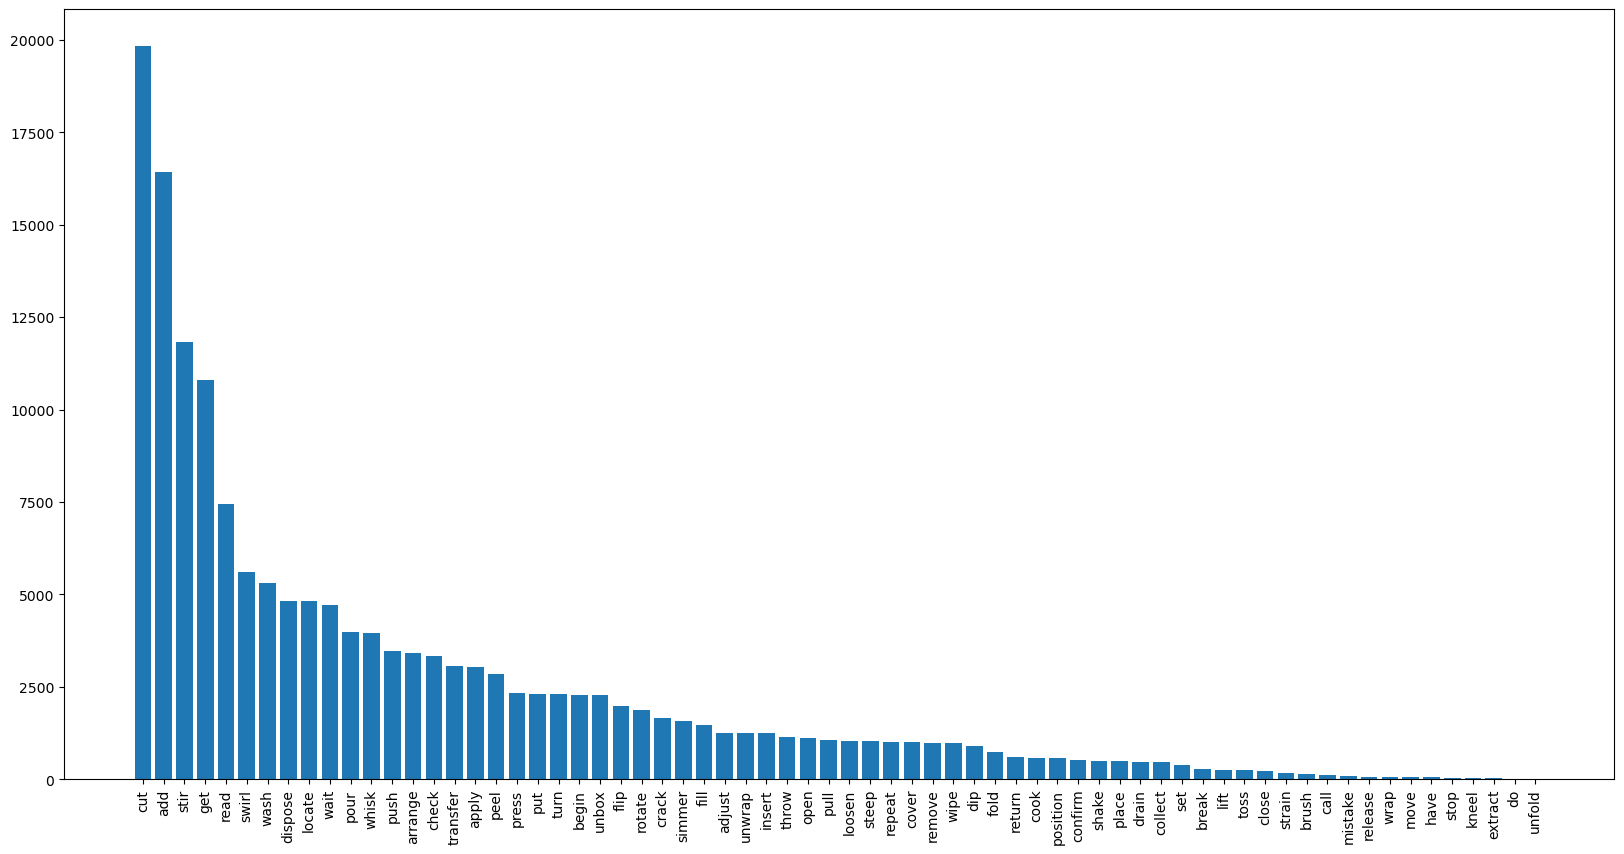

<Figure size 640x480 with 0 Axes>

In [114]:
plt.figure(figsize=(20,10))
plt.bar(result['label_name_x'], result['count_x'])
plt.xticks(rotation=90)
plt.show()
plt.savefig(os.path.join('../reports', 'img', 'dataset_analysis', 'keystep_verbs_distribution_train'), format='svg')

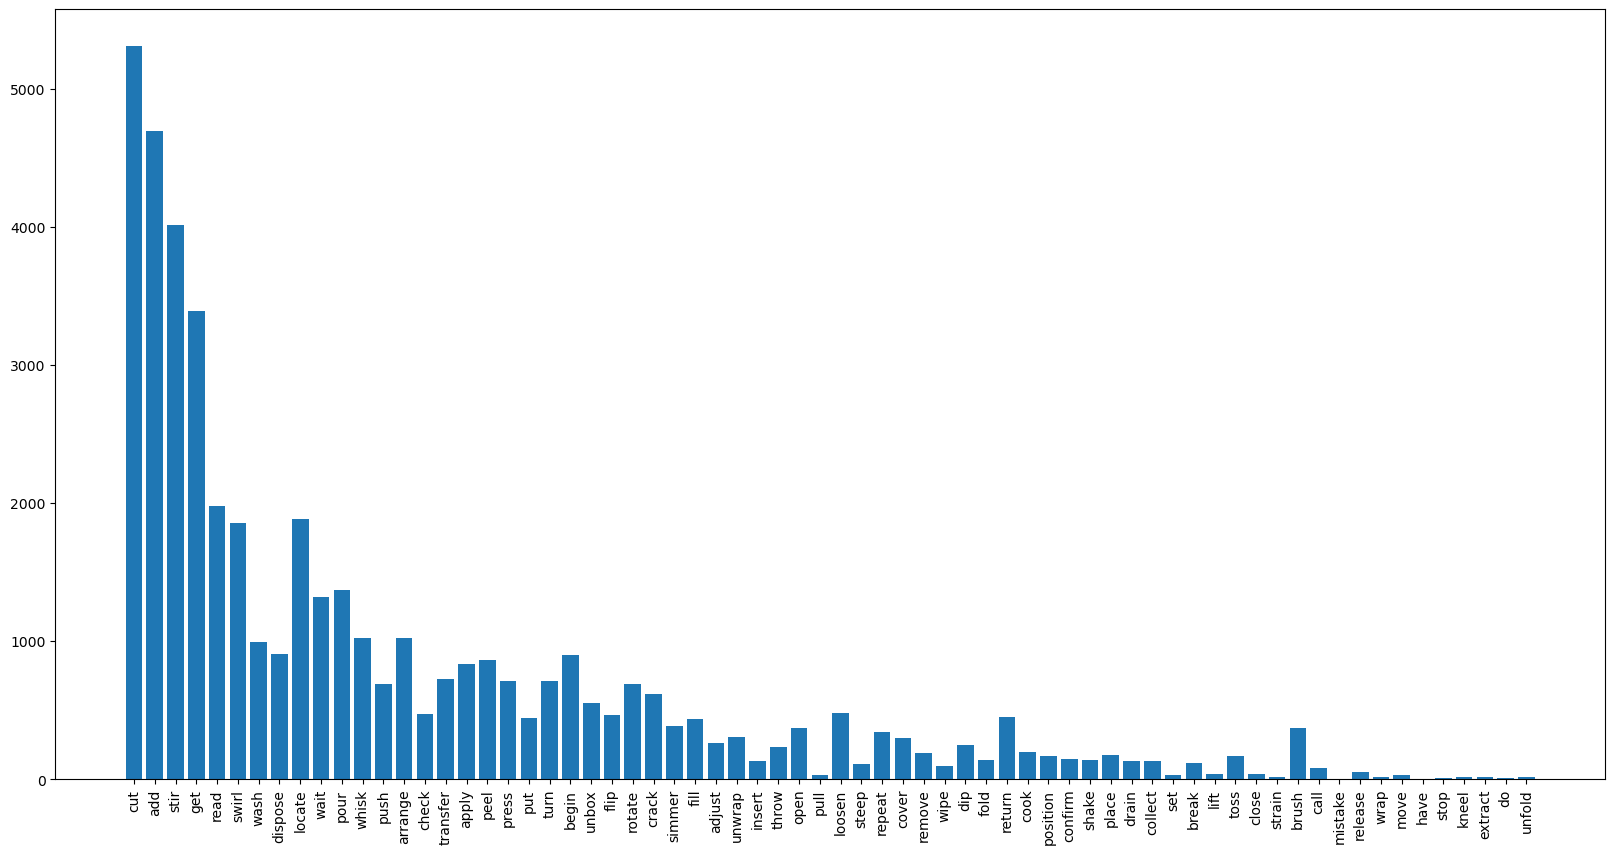

<Figure size 640x480 with 0 Axes>

In [115]:
plt.figure(figsize=(20,10))
plt.bar(result['label_name_y'], result['count_y'])
plt.xticks(rotation=90)
plt.show()
plt.savefig(os.path.join('../reports', 'img', 'dataset_analysis', 'keystep_verbs_distribution_valid'), format='svg')

In [ ]:
keystep['vocabulary']

{'3': 'Wash hands',
 '4': 'Wipe hands',
 '7': 'Add almonds',
 '8': 'Add beef',
 '9': 'Add bell peppers',
 '10': 'Add black pepper',
 '12': 'Add cabbage',
 '14': 'Add carrots',
 '15': 'Add celeries',
 '16': 'Add cheese',
 '18': 'Add cherry tomatoes',
 '19': 'Add chili powder',
 '20': 'Add chocolate',
 '21': 'Add cilantro',
 '22': 'Add cinnamon powder',
 '25': 'Add coffee beans',
 '26': 'Add coffee grounds',
 '28': 'Add cucumber',
 '29': 'Add curry powder',
 '31': 'Add dried herbs',
 '33': 'Add eggs',
 '34': 'Add feta cheese',
 '40': 'Add fresh thyme',
 '41': 'Add garlic cloves',
 '42': 'Add garlic paste',
 '43': 'Add garlic powder',
 '44': 'Add fresh ginger',
 '46': 'Add ginger paste',
 '47': 'Add green chilies',
 '49': 'Add honey',
 '50': 'Add hot sauce',
 '52': 'Add ketchup',
 '54': 'Add lemon juice',
 '55': 'Add lettuce',
 '58': 'Add mayonnaise',
 '59': 'Add milk',
 '60': 'Add mustard',
 '62': 'Add noodles',
 '63': 'Add nutmeg',
 '64': 'Add oil',
 '67': 'Add onions',
 '70': 'Add pars

In [ ]:
count = 0
for _, segments in keystep['annotations'].items():
    count += len(segments)
count

3340

### Create sub-task: verbs-only
From `keystep['vocabulary']`, it will be created a mapping between it and a vocaulary of unique verbs.

In [ ]:
def correct_pos_tags(doc, misclassified_verbs):
    corrected_tags = []
    for i, token in enumerate(doc):
        if token.text.lower() in misclassified_verbs:
            corrected_tags.append((token.text, 'VB'))
        else:
            corrected_tags.append((token.text, token.tag_))
    return corrected_tags

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

misclassified_verbs = [
    'wash',
    'peel',
    'wipe',
    'locate',
    'wrap',
    'blow',
    'unbox',
    'unwrap',
    'fix',
    'release',
    'pour',
    'grate',
    'knead',
    'roll',
    'add',
    'cut',
    'remove',
    'dip',
    'dispose',
    'pivot',
    'return',
    'flatten',
    'whisk',
    'transfer',
    'cook'
]


pd.set_option("display.max_rows", None)
labels_mapping = pd.DataFrame(columns=['verb', 'step_unique_id'])

for idx, activity in keystep['vocabulary'].items():
    print(idx, activity)
    activity = activity
    tokens = nlp(activity)
    # tokens = [token.lower() for token in tokens]
    # tokens = nltk.pos_tag(tokens)
    # print(f"{idx}: {activity} -> {tokens.pos_}")
    print(f"{idx}: {activity} -> ", [(token.text, token.tag_) for token in tokens])
    tokens = correct_pos_tags(tokens, misclassified_verbs)
    verb = [token[0] for token in tokens if (str(token[1]).startswith('VB') and not str(token[1]).startswith('VBD'))][0]
    # verb = [token.text for token in tokens if token.tag_.startswith('VB')][0]
    labels_mapping.loc[len(labels_mapping)] = [verb.lower(), idx]
print(labels_mapping.sort_values(by=['verb']))

3 Wash hands
3: Wash hands ->  [('Wash', 'VB'), ('hands', 'NNS')]
4 Wipe hands
4: Wipe hands ->  [('Wipe', 'VB'), ('hands', 'NNS')]
7 Add almonds
7: Add almonds ->  [('Add', 'VB'), ('almonds', 'NNS')]
8 Add beef
8: Add beef ->  [('Add', 'JJ'), ('beef', 'NN')]
9 Add bell peppers
9: Add bell peppers ->  [('Add', 'VB'), ('bell', 'NN'), ('peppers', 'NNS')]
10 Add black pepper
10: Add black pepper ->  [('Add', 'VB'), ('black', 'JJ'), ('pepper', 'NN')]
12 Add cabbage
12: Add cabbage ->  [('Add', 'VB'), ('cabbage', 'NN')]
14 Add carrots
14: Add carrots ->  [('Add', 'VB'), ('carrots', 'NNS')]
15 Add celeries
15: Add celeries ->  [('Add', 'VB'), ('celeries', 'NNS')]
16 Add cheese
16: Add cheese ->  [('Add', 'VB'), ('cheese', 'NN')]
18 Add cherry tomatoes
18: Add cherry tomatoes ->  [('Add', 'VB'), ('cherry', 'NN'), ('tomatoes', 'NNS')]
19 Add chili powder
19: Add chili powder ->  [('Add', 'VB'), ('chili', 'JJ'), ('powder', 'NN')]
20 Add chocolate
20: Add chocolate ->  [('Add', 'VB'), ('chocolat

In [ ]:
len(labels_mapping.verb.unique()), len(labels_mapping)

(109, 665)

In [ ]:
labels_mapping['verb_idx'] = pd.factorize(labels_mapping.verb)[0]

In [ ]:
labels_mapping.to_pickle(os.path.join('../data', 'EgoExo4D', 'verbs_mapping_keystep.pkl'))

### Statistics sub-task

# Investigate spectrograms

In [64]:
import os
import numpy as np
from matplotlib import pyplot as plt
import torchaudio
import librosa
import torchaudio.transforms as T
import torch

In [ ]:
data_dir = os.path.join('/data2', 'EgoExo4D', 'features', 'imu_aria01', 'cmu_bike01_5')
data = np.load(os.path.join(data_dir, 'right.npy')).T

In [ ]:
data.shape

(7, 155368)

In [ ]:
diff = np.round(np.diff(data[0, :]) / 1e9, 3)
max(diff), min(diff)

(0.001, 0.001)

In [ ]:
data_rounded = data
data_rounded[0, :] = np.round(data[0, :] / 1e9, 3)

In [ ]:
data_tensor = torch.tensor(data_rounded[1:, :])

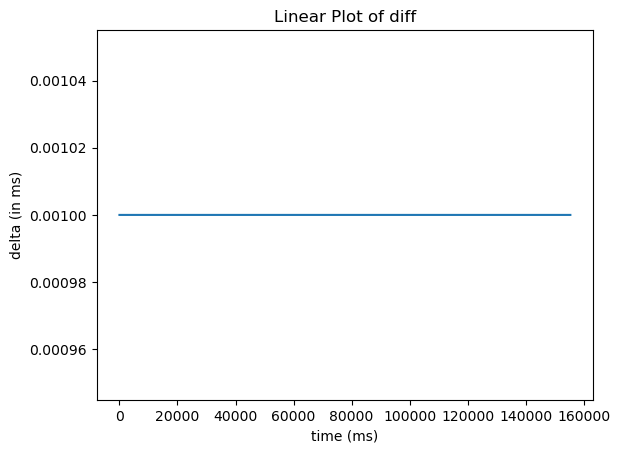

In [ ]:
plt.plot(diff)
plt.title('Linear Plot of diff')
plt.xlabel('time (ms)')
plt.ylabel('delta (in ms)')
plt.show()

In [ ]:
sample_rate * seconds

In [ ]:
seconds = 2
sample_rate = 1e3
start = 500
windowed_data = data_tensor[:, start:int(start + seconds * sample_rate)]
windowed_data.shape

torch.Size([6, 2000])

In [ ]:
windowed_data.max(), windowed_data.min()

(tensor(13.5464, dtype=torch.float64), tensor(-9.7013, dtype=torch.float64))

In [65]:
def normalize_tensor(tensor):
    tensor = torch.from_numpy(tensor)
    min_value = torch.min(tensor)
    max_value = torch.max(tensor)
    normalized_tensor = (tensor - min_value) / (max_value - min_value)
    return normalized_tensor

def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(specgram, origin="lower", aspect="auto", interpolation="nearest")

In [ ]:
SPECGRAM_PARAMS = {
    'window_size': 2,
    'n_fft': 128,
    'hop_length': 4,
    'sampling_rate': 1e3,
    'downsampling_rate': 500,
    'transforms': None,
    'resizes': (64, 192), # patch_size=16 -> (4, 12) = 48 | patch_size=8 -> (8, 24) = 192
}

In [ ]:
prova_2s = torchaudio.functional.resample(windowed_data, 1e3, 500)
# prova_2s = accl_x_interp_torch
# prova_2s = normalize_tensor(prova_2s.numpy())
# 

n_ffts = [128, 256]
hop_length = [2, 4, 8, 16]
amplitude_to_db = T.AmplitudeToDB(stype="power", top_db=90)
specs = []
for i, n_fft in enumerate(n_ffts):
    spectrogram = T.Spectrogram(
        n_fft=n_fft,
        hop_length=4,
        center=True,
        pad_mode="reflect",
        power=2.0,
        normalized=True,
        window_fn=torch.signal.windows.nuttall
    )
    spectrogram.double()

    # 1. spettrogramma
    # 2. da amplitude a dB
    # 3. normalizzare [0,1]
    # prova2s = normalize_tensor(spectrogram(prova_2s).numpy())
    prova = spectrogram(prova_2s)
    # prova = librosa.power_to_db(prova)
    prova = amplitude_to_db(prova)
    # prova = normalize_tensor(prova.numpy())
    specs.append(prova)
    
for i in range(len(specs)):
    print(specs[i].shape) 

torch.Size([6, 65, 251])
torch.Size([6, 129, 251])


In [ ]:
fig, axs = plt.subplots(1, len(specs), figsize=(20,4))
for i, (spec, n_fft) in enumerate(zip(specs, n_ffts)):
    plot_spectrogram(spec[0], ylabel=f"{n_fft=}", ax=axs[i])
    axs[i].set_xlabel(None)

In [ ]:
windowed_data.shape

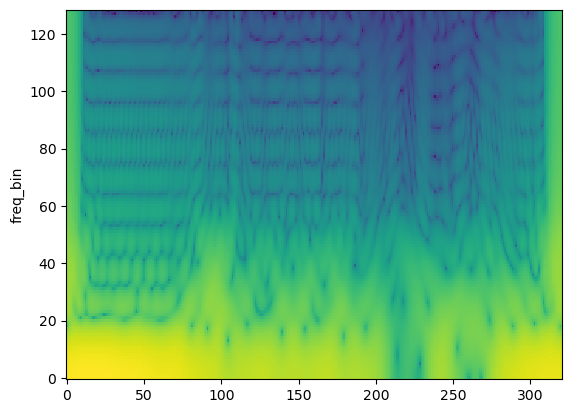

In [ ]:
Fs = 50

waveform = windowed_data.type(torch.float32)
waveform = torchaudio.transforms.Resample(sample_rate, Fs)(waveform)
spectrogram_transform = torchaudio.transforms.Spectrogram(
            n_fft=256, 
            win_length=24,
            hop_length=1, 
            window_fn=torch.hann_window ,
        )

resample_ratio = 320/waveform.shape[1]
resample_target = int(100*resample_ratio)
waveform = torchaudio.transforms.Resample(100, resample_target)(waveform)
# waveform = normalize_tensor(waveform.numpy())
# waveform = (waveform - waveform.mean()) / waveform.std()
spectrogram = spectrogram_transform(waveform) # from [1,320] to [1,129,321]
spectrogram_db = torchaudio.transforms.AmplitudeToDB()(spectrogram)
fbank = spectrogram_db[0, :].squeeze(0).transpose(0,1)[:,:128]
plot_spectrogram(spectrogram_db[0], ylabel="freq_bin", ax=None)

In [ ]:
fbank.shape

torch.Size([321, 128])

In [ ]:
waveform

In [ ]:
spectrogram_db.shape

# EgoExo4D: Pytorch dataset class

In [51]:
%cd ..
%cd src

/home/gatanasio/SSPT_IMU
/home/gatanasio/SSPT_IMU/src


/home/gatanasio/miniconda3/envs/audio-mae/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [52]:
import os
import json
import pickle as pkl
import yaml

from data.egoexo4d import EgoExo4D
from data.dataset import make_dataset
import torch
from torch.nn import DataParallel
from torch.utils.data import DataLoader
from audiomae_pretrain import modeling
from audiomae_ft import load_model

In [53]:
# Load the json file
# takes = pd.read_json(os.path.join(ego_exo_root, 'takes.json'))
ego_exo_root = os.path.join('/data2', 'EgoExo4D') # Replace with your cli's download directory for Ego-Exo4D
data_dir = os.path.join('/data2', 'EgoExo4D')
takes_path = (os.path.join(os.path.dirname(os.getcwd()), 'data', 'EgoExo4D', 'annotations_train.pkl'))
cfg = yaml.load(open(os.path.join(os.path.dirname(os.getcwd()), 'configs', 'IMU-MAE', 'egoexo4d_accl.yaml'), 'r'), Loader=yaml.FullLoader)

In [4]:
SPECGRAM_PARAMS = {
    'window_size': 2,
    'n_fft': 256,
    'win_length': 24,
    'hop_length': 1,
    'sampling_rate': 50,
    'transforms': None,
    'resizes': (128, 320),
    'temporal_points': 160
}

In [ ]:
takes_path

'/home/gatanasio/SSPT_IMU/data/EgoExo4D/annotations_test.pkl'

In [6]:
cfg['dataset']

{'data_dir': '/data2/EgoExo4D',
 'annotations_file': './data/EgoExo4D/annotations_train.pkl',
 'stream_labels': ['imu-left', 'imu-right'],
 'sensors': ['accl'],
 'preload': True,
 'mean': './data/EgoExo4D/mean_std/accl_mean_left.pt',
 'std': './data/EgoExo4D/mean_std/accl_std_left.pt'}

In [54]:
cfg['dataset'] = {
    **cfg['dataset'],
    # 'annotations_file': '.' + cfg['dataset']['annotations_file'],
    'annotations_file': takes_path,
    'mean': '.' + cfg['dataset']['mean'],
    'std': '.' + cfg['dataset']['std'],
}

In [55]:
cfg_args = {
            **cfg['dataset'],
            **cfg['spectrogram_params'][f'sec_{2}']['128x320'],
            "preload": False,
            "task_name": cfg['task_name']
        }

In [56]:
dataset = make_dataset(
            name='egoexo4d',
            is_pretrain=True,
            **cfg_args
            # task_name = cfg['task_name'],
            # preload=True,
            # **cfg['dataset'],
            # **cfg['spectrogram_params'][f'sec_{args.seconds}'][args.matrix_type]
        )

In [10]:
len(dataset)

950513

In [15]:
dataset.takes[0]

{'take_name': 'sfu_cooking_010_7',
 'take_uid': '2272e855-b35c-4ac0-b008-031e119718b5',
 'effective_start_sec': 2114.506591796875,
 'start_sec': 121.81481,
 'end_sec': 123.81481,
 'omnivore_idx': 218}

In [60]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
break_cond = 5
for i, imu in enumerate(dataloader):
    # imu = imu.squeeze(0)
    # print(imu.shape)
    # plot_spectrogram(imu[0].numpy(), ylabel="freq_bin", ax=None)
    if i == break_cond:
        break

In [ ]:
cfg['model']

{'in_chans': 3,
 'mask_2d': False,
 'use_custom_patch': False,
 'alpha': 0.9,
 'mode': 0,
 'split_pos': False,
 'pos_trainable': False,
 'decoder_mode': 1,
 'no_shift': False,
 'use_nce': False,
 'norm_pix_loss': True,
 'audio_exp': False,
 'name': 'mae_vit_small_patch'}

In [57]:
mask_ratio = 0.7

In [58]:
model = modeling(
    seconds=2,
    matrix_type='128x320',
    audio_exp=True,
    cfg=cfg,
)
cfg['model']['name'] = 'mae_vit_small_patch'
type = 'mask_ratio{' + str(mask_ratio) + '}_mae_vit_small_patch16/accelerator_state'
checkpoint = os.path.join('../reports/experiments/audio_mae/128x320/egoexo4d/pretrain/', type)
model = load_model(finetune=checkpoint, eval=True, model=model)

/home/gatanasio/miniconda3/envs/audio-mae/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403378171/work/aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Load pre-trained checkpoint from: ../reports/experiments/audio_mae/128x320/egoexo4d/pretrain/mask_ratio{0.7}_mae_vit_small_patch16/accelerator_state
<All keys matched successfully>


In [61]:
emb_enc, mask, ids_restore, _ = model.forward_encoder(imu, mask_ratio, mask_2d=False)
pred, _, _ = model.forward_decoder(emb_enc, ids_restore)  # [N, L, p*p*3]
unpatched_pred = model.unpatchify(pred)

In [66]:
prova = unpatched_pred.squeeze(0)
prova.shape

torch.Size([3, 128, 320])

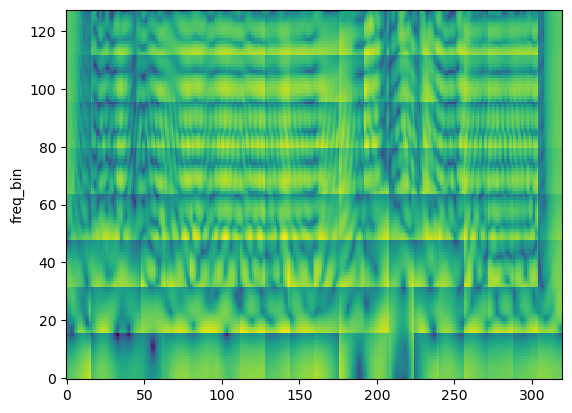

In [67]:
plot_spectrogram(prova[0].detach().numpy(), ylabel="freq_bin", ax=None)

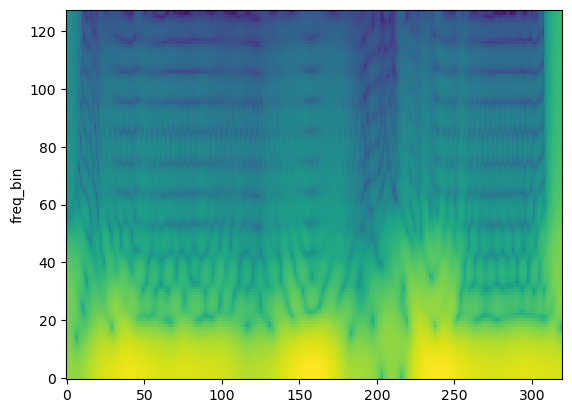

In [68]:
imu_to_numpy = imu.squeeze(0).detach().numpy()
plot_spectrogram(imu_to_numpy[2], ylabel="freq_bin", ax=None)

In [ ]:
recon = prova.detach().numpy()
recon.shape

(3, 128, 320)

In [ ]:
specs = [
    imu_to_numpy[2],
    recon[2],
]

In [ ]:
fig, axs = plt.subplots(1, len(specs), figsize=(13,4))
for i, spec in enumerate(specs):
    plot_spectrogram(spec, ylabel='freq_bin', ax=axs[i])
    axs[i].set_xlabel(None)

In [71]:
import torch
import numpy as np
import matplotlib.pyplot as plt


def show_image(image, title=''):
    plt.imshow(image, origin="lower", aspect="auto" ,interpolation="bicubic")
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def visualize(pixel_values, model):
    # forward pass
    emb_enc, mask, ids_restore, _ = model.forward_encoder(pixel_values, mask_ratio, mask_2d=False)
    pred, _, _ = model.forward_decoder(emb_enc, ids_restore)  # [N, L, p*p*3]
    # outputs = model(pixel_values)
    y = model.unpatchify(pred)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()
    
    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_size**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', pixel_values)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [30, 5]
    print(x[0, :, :, 0].shape)
    plt.subplot(1, 4, 1)
    show_image(x[0, :, :, 0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0, :, :, 0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0, :, :, 0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0, :, :, 0], "reconstruction + visible")

    plt.show()

torch.Size([128, 320])


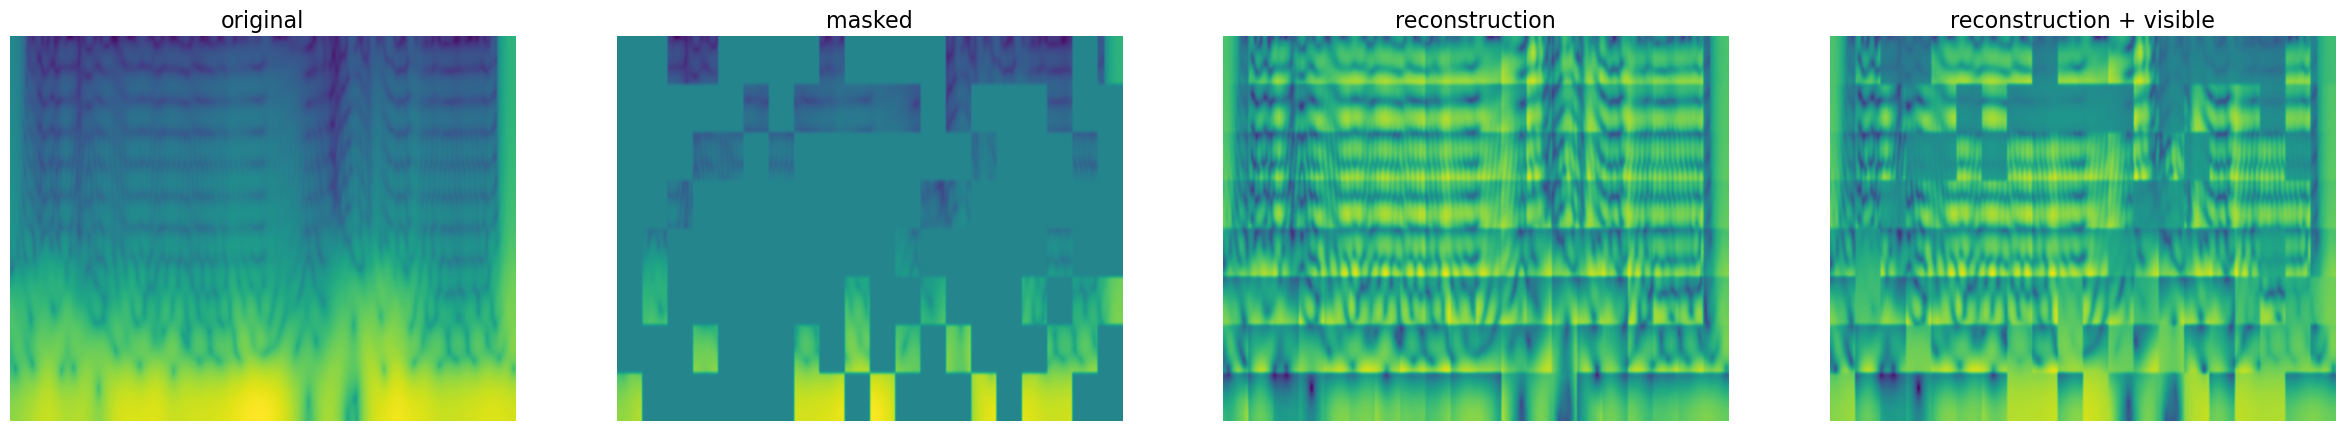

In [72]:
visualize(imu, model)

In [74]:
prova.max(), prova.min(), imu.max(), imu.min()

(tensor(2.9305, grad_fn=<MaxBackward1>),
 tensor(-4.9162, grad_fn=<MinBackward1>),
 tensor(2.4839),
 tensor(-2.6011))

In [73]:
dataset.mean, dataset.std

(tensor([-32.9668, -23.8552, -30.4271]), tensor([27.2785, 26.8870, 27.1692]))